In [1]:
# Imports
from dataloader import get_utkface_loaders
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from models import *

In [2]:
# Load data
target_column = 'age'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=10000, num_valid=2000, num_test=2000)

100%|██████████| 23708/23708 [00:00<00:00, 742760.59it/s]


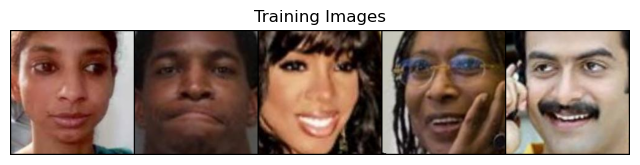

Age: [27. 31. 26. 40. 35.]


In [4]:
# Print 5 images with the age label
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(images[:5], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
print('Age:', labels[:5].numpy())

In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Classification ResNet

In [3]:
def check_accuracy_classification(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [4]:
print_every = 100
def train_classification(model, optimizer, epochs=5):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_classification(valid_loader, model)
                print()
    return check_accuracy_classification(valid_loader, model)

In [10]:
num_class = 20
print_every = 100
target_column = 'age_class'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=10000, num_valid=2000, num_test=2000)
model_resenet_class = ResNetClassification(num_class=num_class)
optimizer = optim.Adam(model_resenet_class.parameters(), lr=1e-3)
train_classification(model_resenet_class, optimizer, epochs=5)

100%|██████████| 23708/23708 [00:00<00:00, 374090.75it/s]


Epoch 0, Iteration 100, loss = 2.2526
Got 482 / 2000 correct (24.10)

Epoch 1, Iteration 100, loss = 2.3928
Got 381 / 2000 correct (19.05)

Epoch 2, Iteration 100, loss = 2.3872
Got 472 / 2000 correct (23.60)

Epoch 3, Iteration 100, loss = 1.9983
Got 417 / 2000 correct (20.85)

Epoch 4, Iteration 100, loss = 2.0916
Got 520 / 2000 correct (26.00)

Got 572 / 2000 correct (28.60)


0.286

In [11]:
# Check the accuracy of the model
check_accuracy_classification(test_loader, model_resenet_class)

Got 611 / 2000 correct (30.55)


0.3055

# Regression ResNet

In [12]:
def check_accuracy_regression(loader, model): 
    num_correct = 0
    num_samples = 0
    mean_error = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            # Correct if prediction is within 5 years of the actual age
            num_correct += (torch.abs(scores - y) <= 2.5).sum()
            mean_error += torch.abs(scores - y).sum()
            num_samples += scores.size(0)
        acc = float(num_correct) / num_samples
        mean_error = float(mean_error) / num_samples
        print('Got %d / %d correct (%.2f), Correct if abs(prediction - actual) ≤ 2.5' % (num_correct, num_samples, 100 * acc))
    return acc, mean_error

In [16]:
def train_regression(model, optimizer, epochs=5):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.mse_loss(scores, y.float())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_regression(valid_loader, model)
                print()
    return check_accuracy_regression(valid_loader, model)

In [17]:
print_every = 100
target_column = 'age'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=10000, num_valid=2000, num_test=2000)
model_resenet_regression = ResNetRegression()
optimizer = optim.Adam(model_resenet_regression.parameters(), lr=1e-3)
train_regression(model_resenet_regression, optimizer, epochs=5)

100%|██████████| 23708/23708 [00:00<00:00, 348809.31it/s]


Epoch 0, Iteration 100, loss = 309.6028
Got 279 / 2000 correct (13.95), Correct if abs(prediction - actual) ≤ 2.5

Epoch 1, Iteration 100, loss = 343.8014
Got 289 / 2000 correct (14.45), Correct if abs(prediction - actual) ≤ 2.5

Epoch 2, Iteration 100, loss = 246.6823
Got 107 / 2000 correct (5.35), Correct if abs(prediction - actual) ≤ 2.5

Epoch 3, Iteration 100, loss = 226.5504
Got 255 / 2000 correct (12.75), Correct if abs(prediction - actual) ≤ 2.5

Epoch 4, Iteration 100, loss = 183.7250
Got 298 / 2000 correct (14.90), Correct if abs(prediction - actual) ≤ 2.5

Got 227 / 2000 correct (11.35), Correct if abs(prediction - actual) ≤ 2.5


(0.1135, 11.858423828125)

In [18]:
# Check accuracy
check_accuracy_regression(test_loader, model_resenet_regression)

Got 262 / 2000 correct (13.10), Correct if abs(prediction - actual) ≤ 2.5


(0.131, 11.6334345703125)

# ResNet with pretrained weights

In [5]:
num_class = 20
print_every = 100
target_column = 'age_class'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=10000, num_valid=2000, num_test=2000)
model_resnet_pretrained = ResNetPretrained(num_class=num_class)
optimizer = optim.Adam(model_resnet_pretrained.parameters(), lr=1e-3)
train_classification(model_resnet_pretrained, optimizer, epochs=5)

100%|██████████| 23708/23708 [00:00<00:00, 359582.41it/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/pnataraj/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s]


Epoch 0, Iteration 100, loss = 2.2133
Got 553 / 2000 correct (27.65)

Epoch 1, Iteration 100, loss = 1.8842
Got 629 / 2000 correct (31.45)

Epoch 2, Iteration 100, loss = 1.8179
Got 675 / 2000 correct (33.75)

Epoch 3, Iteration 100, loss = 1.5510
Got 655 / 2000 correct (32.75)

Epoch 4, Iteration 100, loss = 1.7330
Got 721 / 2000 correct (36.05)

Got 654 / 2000 correct (32.70)


0.327

In [6]:
check_accuracy_classification(test_loader, model_resnet_pretrained)

Got 693 / 2000 correct (34.65)


0.3465

# ResNet with Slower Downsampling with more layers and without Max Pooling

In [5]:
num_class = 20
print_every = 100
target_column = 'age_class'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=10000, num_valid=2000, num_test=2000)
model_resenet_slow_ds = ResNetSlowDownSample(num_class=num_class)
optimizer = optim.Adam(model_resenet_slow_ds.parameters(), lr=1e-3)
train_classification(model_resenet_slow_ds, optimizer, epochs=5)

100%|██████████| 23708/23708 [00:00<00:00, 339413.18it/s]


Epoch 0, Iteration 100, loss = 2.1155
Got 522 / 2000 correct (26.10)

Epoch 1, Iteration 100, loss = 2.0406
Got 600 / 2000 correct (30.00)

Epoch 2, Iteration 100, loss = 2.0239
Got 602 / 2000 correct (30.10)

Epoch 3, Iteration 100, loss = 2.0652
Got 627 / 2000 correct (31.35)

Epoch 4, Iteration 100, loss = 1.8414
Got 292 / 2000 correct (14.60)

Got 561 / 2000 correct (28.05)


0.2805

In [6]:
check_accuracy_classification(test_loader, model_resenet_slow_ds)

Got 561 / 2000 correct (28.05)


0.2805

# ResNet With Dropout

In [5]:
num_class = 20
print_every = 100
target_column = 'age_class'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=10000, num_valid=2000, num_test=2000)
model_resenet_dropout = ResNetDropout(num_class=num_class)
optimizer = optim.Adam(model_resenet_dropout.parameters(), lr=1e-3)
train_classification(model_resenet_dropout, optimizer, epochs=5)

100%|██████████| 23708/23708 [00:00<00:00, 348065.76it/s]


Epoch 0, Iteration 100, loss = 2.2445
Got 593 / 2000 correct (29.65)

Epoch 1, Iteration 100, loss = 1.9717
Got 606 / 2000 correct (30.30)

Epoch 2, Iteration 100, loss = 1.8540
Got 587 / 2000 correct (29.35)

Epoch 3, Iteration 100, loss = 2.0040
Got 620 / 2000 correct (31.00)

Epoch 4, Iteration 100, loss = 1.8529
Got 637 / 2000 correct (31.85)

Got 691 / 2000 correct (34.55)


0.3455

In [6]:
check_accuracy_classification(test_loader, model_resenet_dropout)

Got 695 / 2000 correct (34.75)


0.3475

# Optimize Hyperparameters

In [ ]:
batch_sizes = [16, 32, 64, 128]
optmizers = ["adam", "sgd"]
lrs = [1e-3, 1e-2, 1e-4]
training_data_sizes = [10000, 1000, 5000, 15000]

best_batch_size = batch_sizes[0]
best_optimizer = optmizers[0]
best_lr = lrs[0]
best_training_data_size = training_data_sizes[0]
best_accuracy = 0

num_class = 20
print_every = 100
target_column = 'age_class'

In [ ]:
def get_optim(optimizer_name, model, lr):
    if optimizer_name == "adam":
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "sgd":
        return optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError("Invalid optimizer name")

## Optimize Batch Size

In [ ]:
for batch_size in batch_sizes:
    num_train = best_training_data_size
    num_valid= num_train // 5
    num_test = num_valid
    train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=batch_size, num_train=num_train, num_valid=num_valid, num_test=num_test)
    model = ResNetDropout(num_class=num_class)
    optimizer = get_optim(best_optimizer, model, best_lr)
    accuracy = train_classification(model_resenet_dropout, optimizer, epochs=5)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_batch_size = batch_size

In [ ]:
print("Best batch size:", best_batch_size)

## Optimize optimizer

In [ ]:
for optimizer in optmizers[1:]:
    num_train = best_training_data_size
    num_valid= num_train // 5
    num_test = num_valid
    train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=best_batch_size, num_train=num_train, num_valid=num_valid, num_test=num_test)
    model = ResNetDropout(num_class=num_class)
    optimizer = get_optim(optimizer, model, best_lr)
    acc = train_classification(model_resenet_dropout, optimizer, epochs=5)
    if acc > best_accuracy:
        best_accuracy = acc
        best_optimizer = optimizer

In [ ]:
print("Best optimizer:", best_optimizer)

## Optimize LR

In [ ]:
for lr in lrs[1:]:
    num_train = best_training_data_size
    num_valid= num_train // 5
    num_test = num_valid
    train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=best_batch_size, num_train=num_train, num_valid=num_valid, num_test=num_test)
    model = ResNetDropout(num_class=num_class)
    optimizer = get_optim(optimizer, model, lr)
    acc = train_classification(model_resenet_dropout, best_optimizer, epochs=5)
    if acc > best_accuracy:
        best_accuracy = acc
        best_lr = lr

In [ ]:
print("Best learning rate:", best_lr)

## Optimize training data size

In [ ]:
for training_data_size in training_data_sizes[1:]:
    num_train = training_data_size
    num_valid= num_train // 5
    num_test = num_valid
    train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=best_batch_size, num_train=num_train, num_valid=num_valid, num_test=num_test)
    model = ResNetDropout(num_class=num_class)
    optimizer = get_optim(best_optimizer, model, lr)
    acc = train_classification(model_resenet_dropout, best_optimizer, epochs=5)
    if acc > best_accuracy:
        best_accuracy = acc
        best_training_data_size = training_data_size

In [ ]:
print("Best training data size:", best_training_data_size)

# Best Configuration